In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import requests
import gzip
import re
import math
from datetime import datetime
from datetime import timedelta

### Calculate Hourly Production Cost 

In [2]:
pjm_df = pandas.read_csv('/home/amy/simple_dispatch/test/cems.csv')
fuel_price_df = pandas.read_csv('/home/amy/simple_dispatch/weekly/fuel_price.csv')
vom = pandas.read_csv('/home/amy/simple_dispatch/vom1.csv')

vom = vom[['orispl_unit', 'vom']]

# Remove PJM outliers 
pjm_df = pjm_df[(pjm_df.mwh >= 10.0) & (pjm_df.heat_rate <= 30.0)] 

fuel_price_2840 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['2840_3'])]
fuel_price_2828 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['2828_1'])]
fuel_price_593 = fuel_price_df[fuel_price_df['orispl_unit'].isin(['593_5'])]
pjm_df = pjm_df[pjm_df['orispl_unit'].isin(['2840_3', '2828_1', '593_5'])]

fuel_price_2840 = fuel_price_2840.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_2840 = fuel_price_2840.T
fuel_price_2840['t'] = range(len(fuel_price_2840)) 
fuel_price_2840['t'] = fuel_price_2840['t'] + 1
fuel_price_2840['orispl_unit'] = '2840_3'

fuel_price_2828 = fuel_price_2828.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_2828 = fuel_price_2828.T
fuel_price_2828['t'] = range(len(fuel_price_2828)) 
fuel_price_2828['t'] = fuel_price_2828['t'] + 1
fuel_price_2828['orispl_unit'] = '2828_1'

fuel_price_593 = fuel_price_593.drop(['Unnamed: 0', 'orispl_unit'], axis=1)
fuel_price_593 = fuel_price_593.T
fuel_price_593['t'] = range(len(fuel_price_593)) 
fuel_price_593['t'] = fuel_price_593['t'] + 1
fuel_price_593['orispl_unit'] = '593_5'

for df in [fuel_price_2840, fuel_price_2828, fuel_price_593]:
    df.columns = ['fuel_price', 't', 'orispl_unit']

fuel_price_df = pandas.concat([fuel_price_2840, fuel_price_2828, fuel_price_593], axis = 0)

temp = pandas.DataFrame(pjm_df.date.str.split('-').tolist(), columns=['month', 'day', 'year'], index=pjm_df.index).astype(float)
pjm_df['monthday'] = temp.year*10000 + temp.month*100 + temp.day

pjm_df['t'] = 52

for t in np.arange(52)+1:
    start = (datetime.strptime('2012-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t-1)-1)).strftime('%Y-%m-%d') 
    end = (datetime.strptime('2012-01-01', '%Y-%m-%d') + timedelta(days=7.05*(t)-1)).strftime('%Y-%m-%d') 
    start_monthday = float(start[0:4])*10000 + float(start[5:7])*100 + float(start[8:])
    end_monthday = float(end[0:4])*10000 + float(end[5:7])*100 + float(end[8:])
    #slice the data for the days corresponding to the time series period, t
    pjm_df.loc[(pjm_df.monthday >= start_monthday) & (pjm_df.monthday < end_monthday), 't'] = t

# Merge the dfs 
df = pandas.merge(pjm_df, fuel_price_df, on=['orispl_unit', 't'], how='left')
df = pandas.merge(df, vom, on=['orispl_unit'], how='left')

df['fuel_cost'] = df['heat_rate'] * df['fuel_price']
df['vom_cost'] = df['vom'] * df['mwh']
df['production_cost'] = df['heat_rate'] * df['fuel_price'] + df['vom'] * df['mwh']

### Production Cost and Relationships 
**Data** 
- Production cost = heat rate * fuel price + variable operation and maintenance * electricity generated 
- Heat input (mmtbu): directly from CEMS 
- Electricity generated (mwh): directly from CEMS
- Total CO2, SO2, NOx emissions 
- Heat rate = heat input / electricity generated 
- VOM: \$ / mwh, from a paper 
- CO2 Emissions rate = total CO2 emissions / electricity generated (mwh) 

**Relationships** 
- Looked at relationships between fuel cost (heat rate * fuel price) and variable operation and maintenance ($ / mwh * total generation) 
- Looked at data from three different plants (gas, oil, coal) on an hourly basis 

In [3]:
gas = df[df['orispl_unit'].isin(['2840_3'])]
coal = df[df['orispl_unit'].isin(['2828_1'])]
oil = df[df['orispl_unit'].isin(['593_5'])]

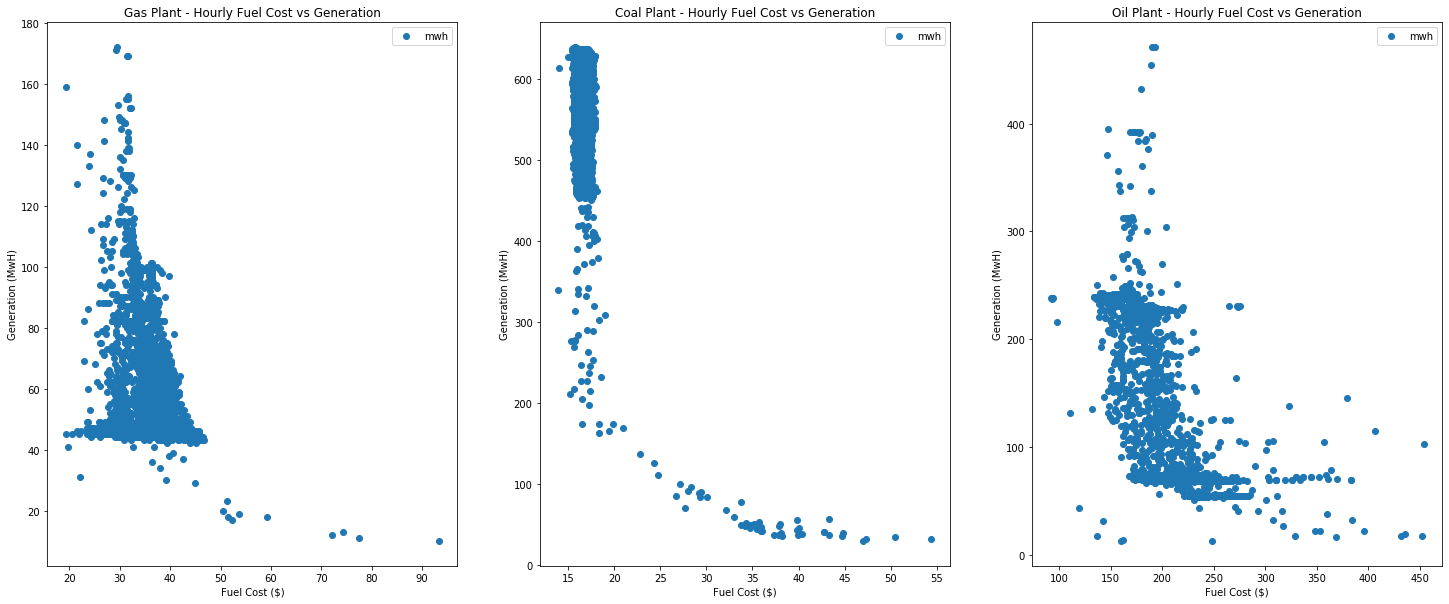

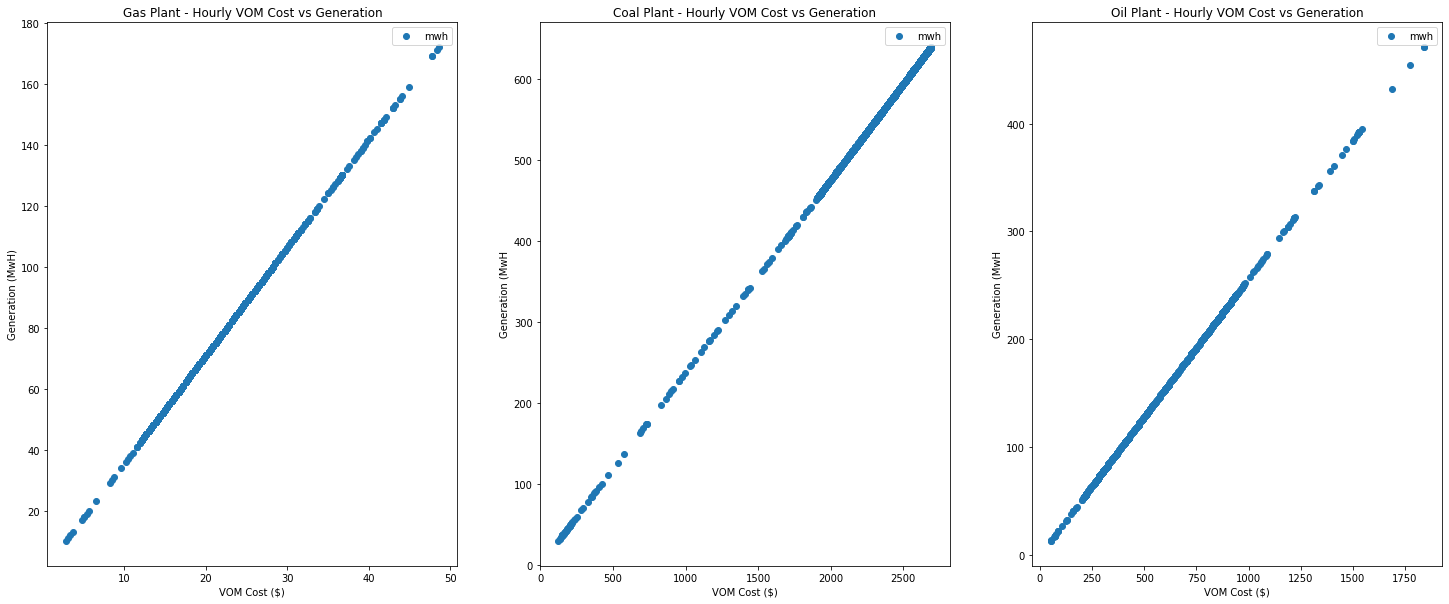

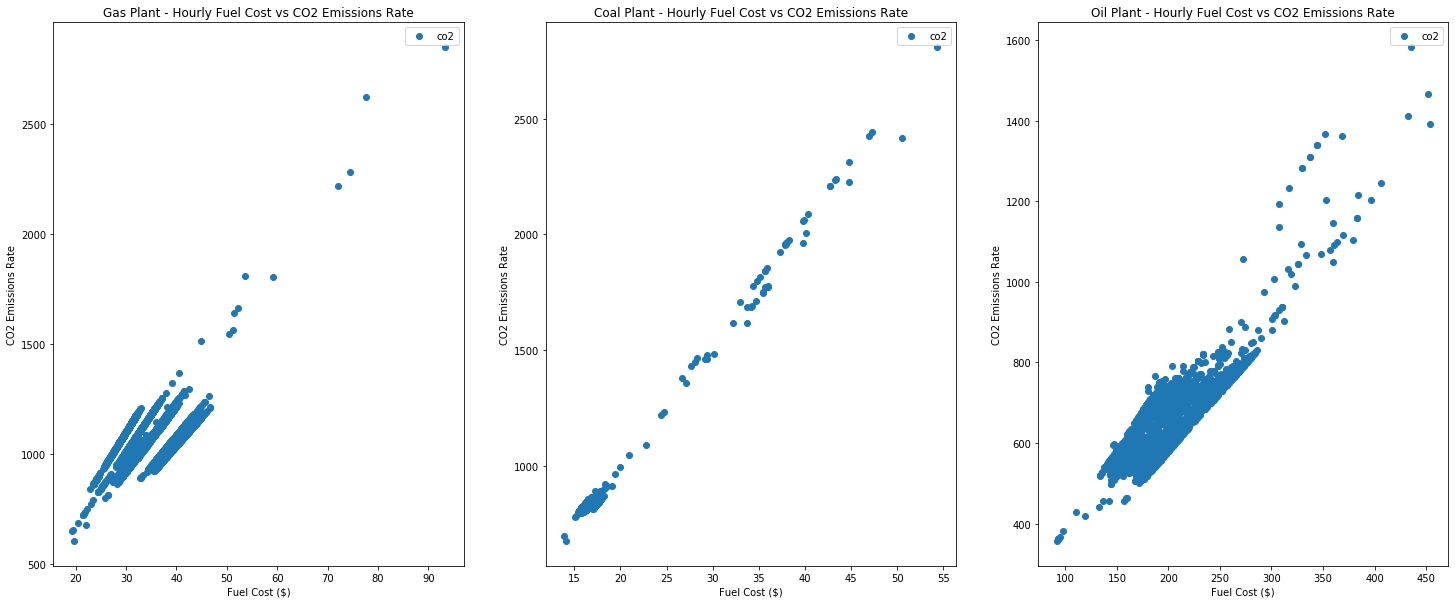

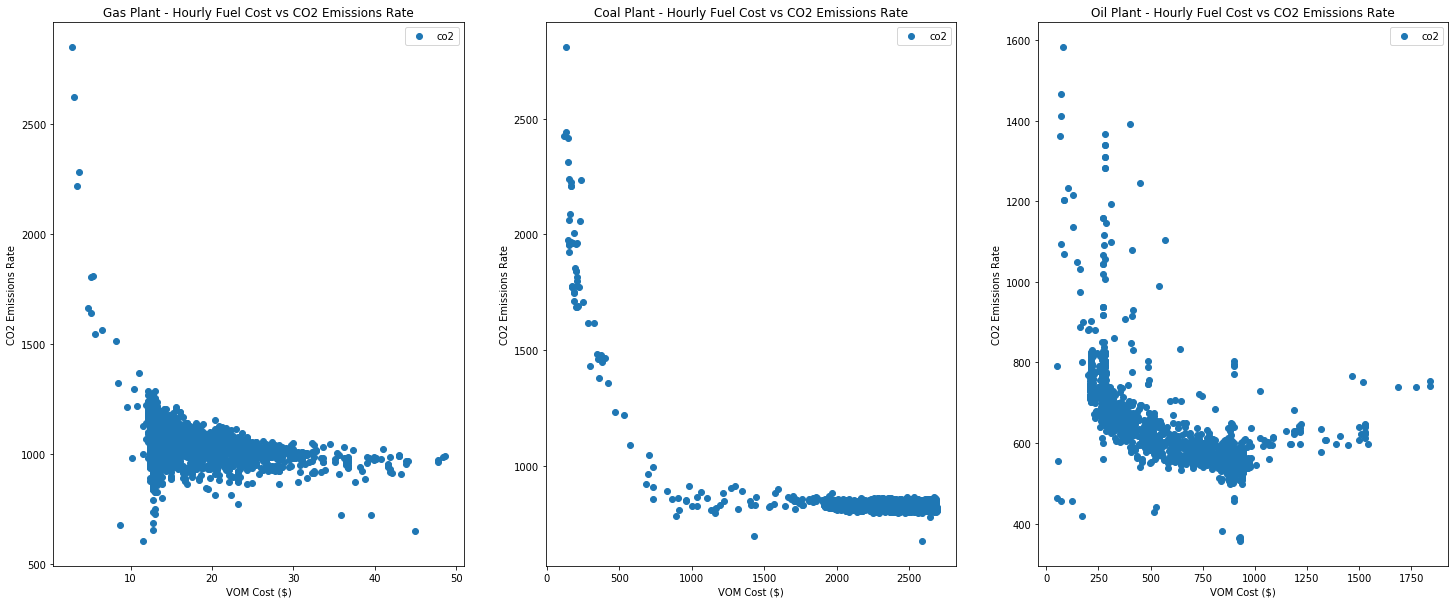

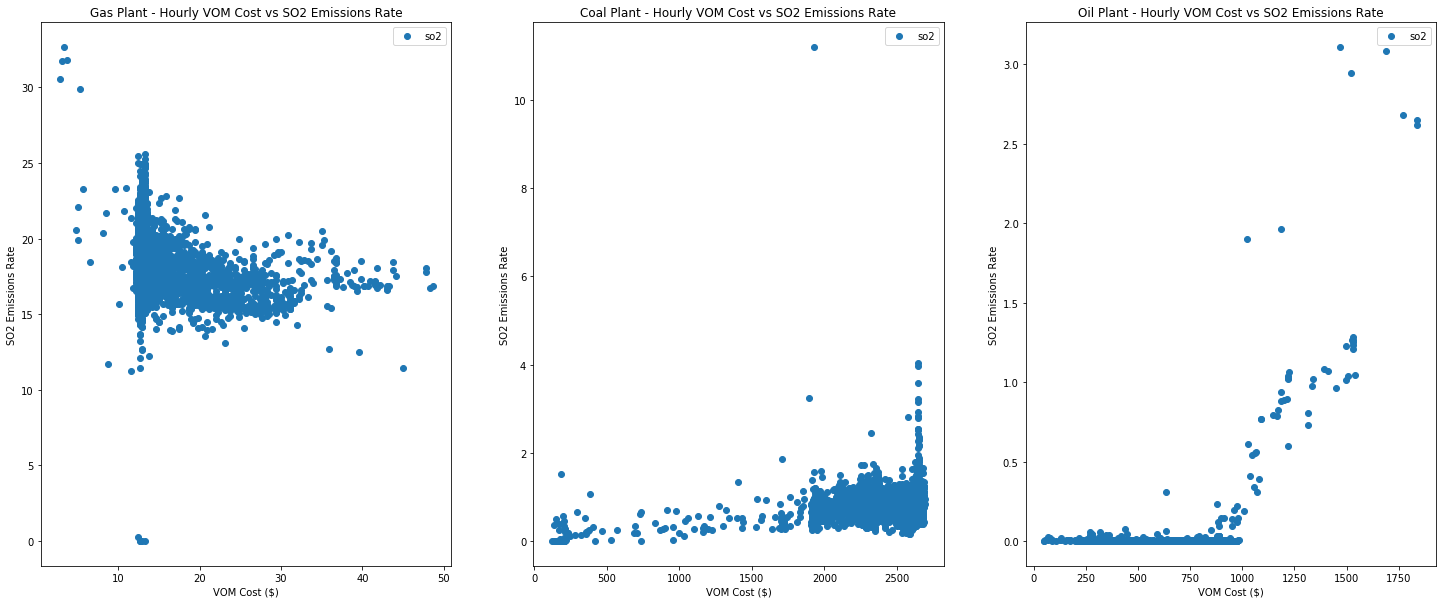

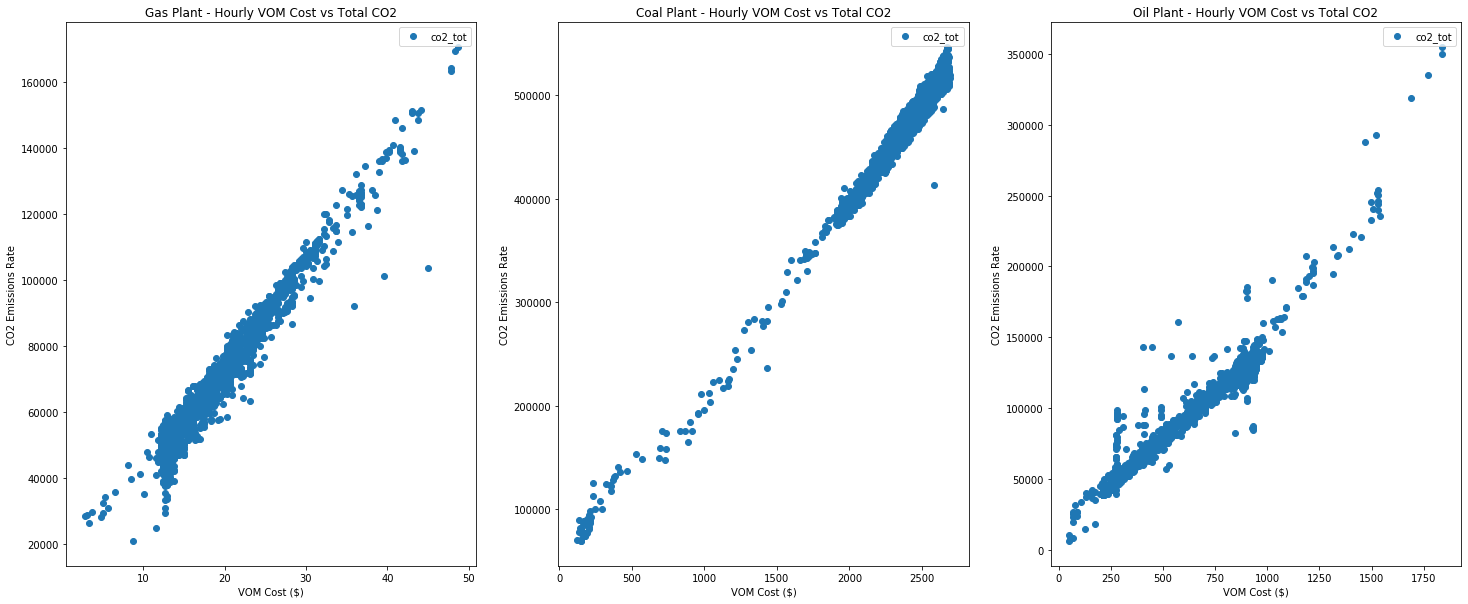

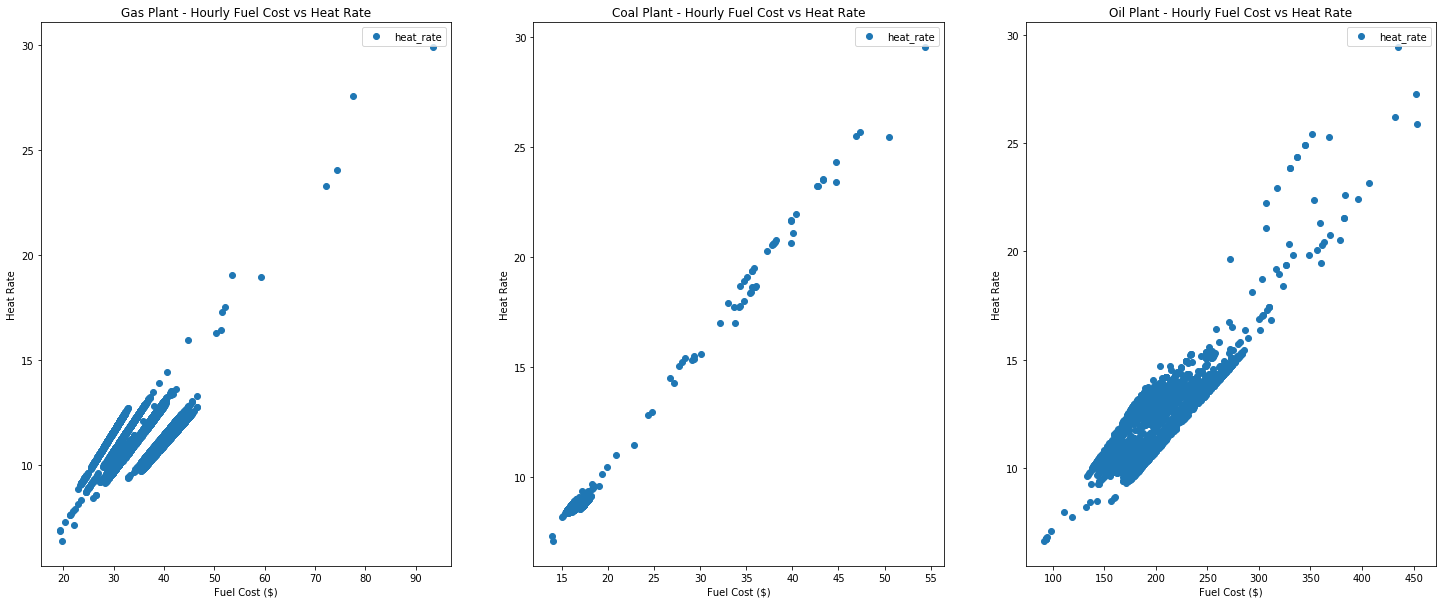

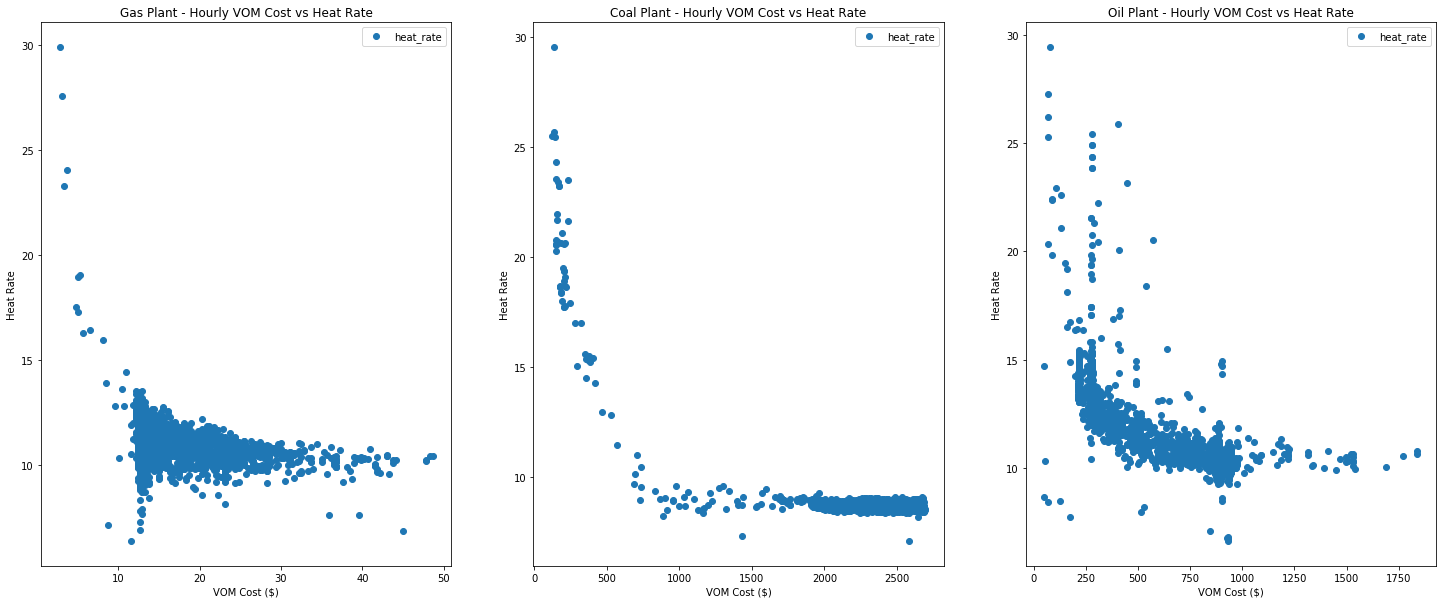

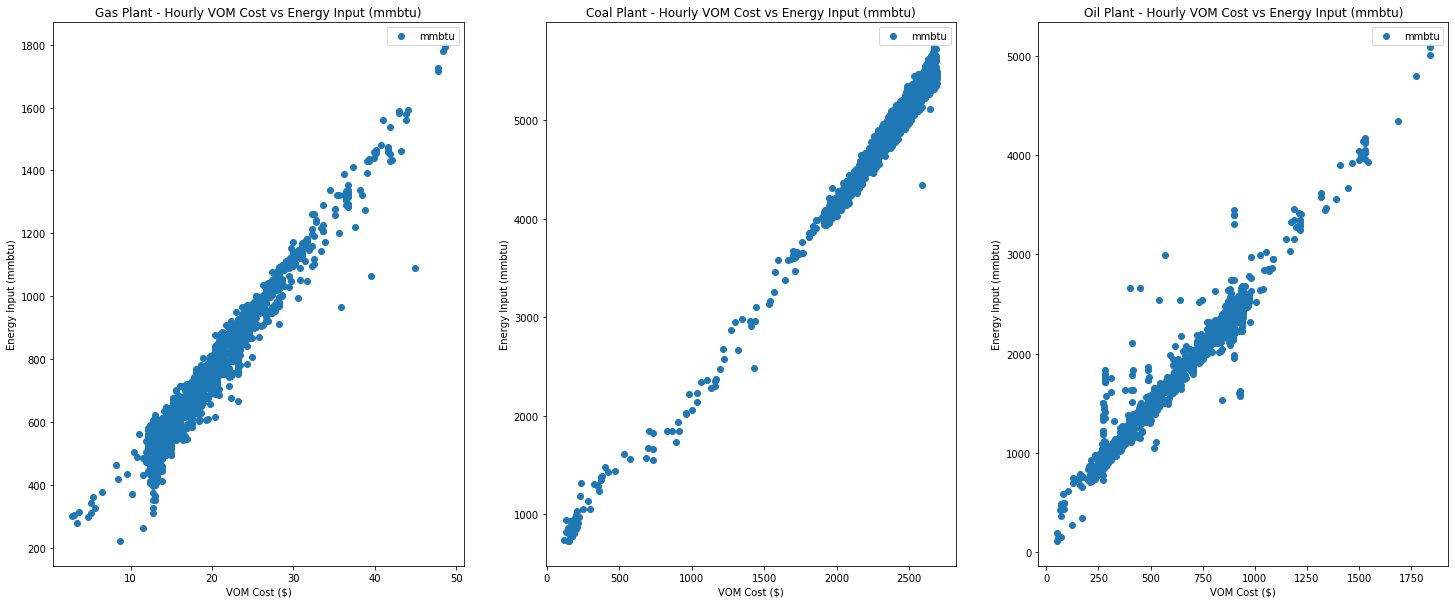

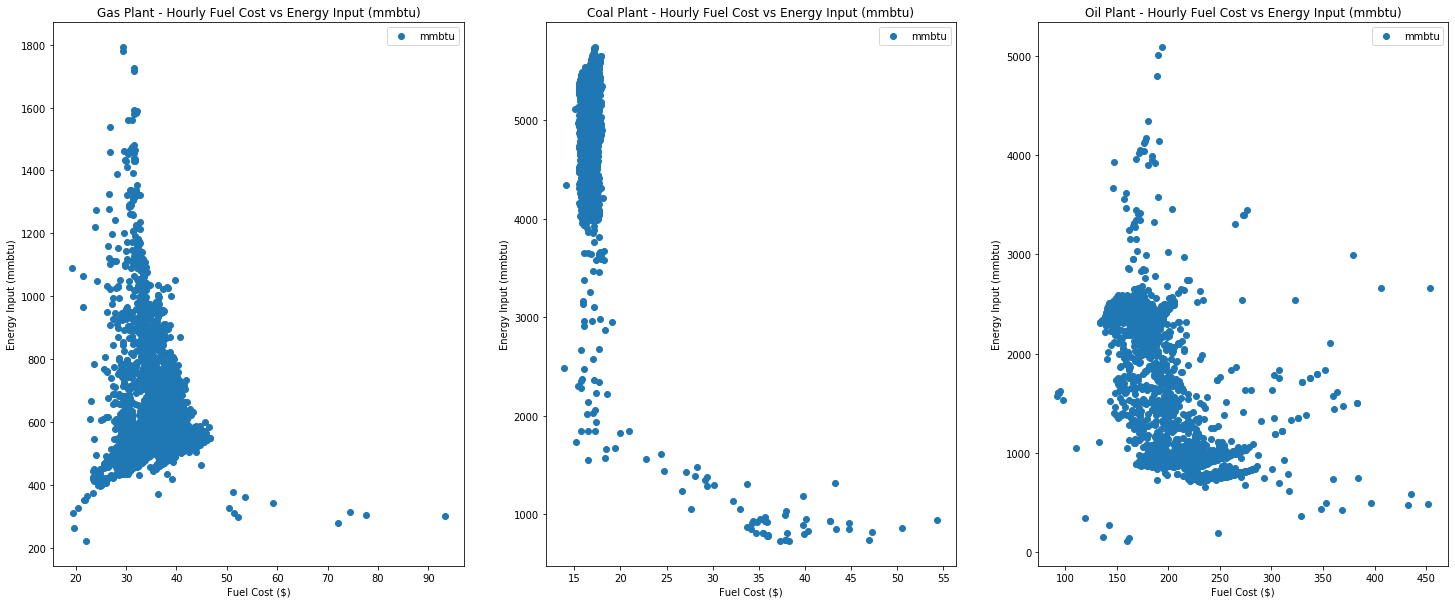

In [5]:
# Fuel Cost vs Generation
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='fuel_cost', y='mwh', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly Fuel Cost vs Generation')  
ax.set_xlabel('Fuel Cost ($)')
ax.set_ylabel('Generation (MwH)')

coal.plot(x='fuel_cost', y='mwh', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly Fuel Cost vs Generation')  
ax2.set_xlabel('Fuel Cost ($)')
ax2.set_ylabel('Generation (MwH)')

oil.plot(x='fuel_cost', y='mwh', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly Fuel Cost vs Generation')  
ax3.set_xlabel('Fuel Cost ($)')
ax3.set_ylabel('Generation (MwH)')

plt.show()

# VOM Cost vs Generation
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='mwh', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly VOM Cost vs Generation')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('Generation (MwH)')

coal.plot(x='vom_cost', y='mwh', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly VOM Cost vs Generation')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('Generation (MwH')

oil.plot(x='vom_cost', y='mwh', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly VOM Cost vs Generation')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('Generation (MwH')

plt.show()


# Fuel Cost vs CO2 Emissions Rate
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='fuel_cost', y='co2', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax.set_xlabel('Fuel Cost ($)')
ax.set_ylabel('CO2 Emissions Rate')

coal.plot(x='fuel_cost', y='co2', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax2.set_xlabel('Fuel Cost ($)')
ax2.set_ylabel('CO2 Emissions Rate')

oil.plot(x='fuel_cost', y='co2', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax3.set_xlabel('Fuel Cost ($)')
ax3.set_ylabel('CO2 Emissions Rate')
plt.show()

# VOM Cost vs CO2 Emissions Rate
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='co2', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('CO2 Emissions Rate')

coal.plot(x='vom_cost', y='co2', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('CO2 Emissions Rate')

oil.plot(x='vom_cost', y='co2', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly Fuel Cost vs CO2 Emissions Rate')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('CO2 Emissions Rate')
plt.show()

# VOM Cost vs SO2 Emissions Rate
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='so2', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly VOM Cost vs SO2 Emissions Rate')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('SO2 Emissions Rate')

coal.plot(x='vom_cost', y='so2', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly VOM Cost vs SO2 Emissions Rate')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('SO2 Emissions Rate')

oil.plot(x='vom_cost', y='so2', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly VOM Cost vs SO2 Emissions Rate')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('SO2 Emissions Rate')
plt.show()

# VOM Cost vs CO2 Total 
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='co2_tot', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly VOM Cost vs Total CO2')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('CO2 Emissions Rate')

coal.plot(x='vom_cost', y='co2_tot', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly VOM Cost vs Total CO2')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('CO2 Emissions Rate')

oil.plot(x='vom_cost', y='co2_tot', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly VOM Cost vs Total CO2')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('CO2 Emissions Rate')
plt.show()

# Fuel Cost vs Heat Rate 
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='fuel_cost', y='heat_rate', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly Fuel Cost vs Heat Rate')  
ax.set_xlabel('Fuel Cost ($)')
ax.set_ylabel('Heat Rate')

coal.plot(x='fuel_cost', y='heat_rate', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly Fuel Cost vs Heat Rate')  
ax2.set_xlabel('Fuel Cost ($)')
ax2.set_ylabel('Heat Rate')

oil.plot(x='fuel_cost', y='heat_rate', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly Fuel Cost vs Heat Rate')  
ax3.set_xlabel('Fuel Cost ($)')
ax3.set_ylabel('Heat Rate')
plt.show()

# VOM Cost vs Heat Rate
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='heat_rate', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly VOM Cost vs Heat Rate')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('Heat Rate')

coal.plot(x='vom_cost', y='heat_rate', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly VOM Cost vs Heat Rate')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('Heat Rate')

oil.plot(x='vom_cost', y='heat_rate', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly VOM Cost vs Heat Rate')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('Heat Rate')
plt.show()

# VOM Cost vs Energy Input (mmbtu)
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='vom_cost', y='mmbtu', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly VOM Cost vs Energy Input (mmbtu)')  
ax.set_xlabel('VOM Cost ($)')
ax.set_ylabel('Energy Input (mmbtu)')

coal.plot(x='vom_cost', y='mmbtu', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly VOM Cost vs Energy Input (mmbtu)')  
ax2.set_xlabel('VOM Cost ($)')
ax2.set_ylabel('Energy Input (mmbtu)')

oil.plot(x='vom_cost', y='mmbtu', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly VOM Cost vs Energy Input (mmbtu)')  
ax3.set_xlabel('VOM Cost ($)')
ax3.set_ylabel('Energy Input (mmbtu)')
plt.show()

# Fuel Cost vs Energy Input (mmbtu)  
fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

gas.plot(x='fuel_cost', y='mmbtu', style='o', ax=ax)  
ax.set_title('Gas Plant - Hourly Fuel Cost vs Energy Input (mmbtu)')  
ax.set_xlabel('Fuel Cost ($)')
ax.set_ylabel('Energy Input (mmbtu)')

coal.plot(x='fuel_cost', y='mmbtu', style='o', ax=ax2)  
ax2.set_title('Coal Plant - Hourly Fuel Cost vs Energy Input (mmbtu)')  
ax2.set_xlabel('Fuel Cost ($)')
ax2.set_ylabel('Energy Input (mmbtu)')

oil.plot(x='fuel_cost', y='mmbtu', style='o', ax=ax3)  
ax3.set_title('Oil Plant - Hourly Fuel Cost vs Energy Input (mmbtu)')  
ax3.set_xlabel('Fuel Cost ($)')
ax3.set_ylabel('Energy Input (mmbtu)')
plt.show()